In [1]:
from sklearn.model_selection import train_test_split
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from typing import List
sys.path.append('../../')

from package.data.glm import simple_data
from package.glm.glm import backward_wo_con, fit_wo_con, compute_temp_eff_dim, fit_w_con
from package.directories import eigenvalues_dir
from package.fim.fim import compute_fims_glm
from package.effective_dimension.effective_dimension import EDType
from package.plot_utils.common import *



df = simple_data(num_samples=100000)

train, test = train_test_split(df, test_size=0.3, random_state=42)

# Scaled dataframe for parameter selection
features = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame({'y': df['y']})
df_scaled[features] = scaler.fit_transform(df[features])

# Dependency Heatmap

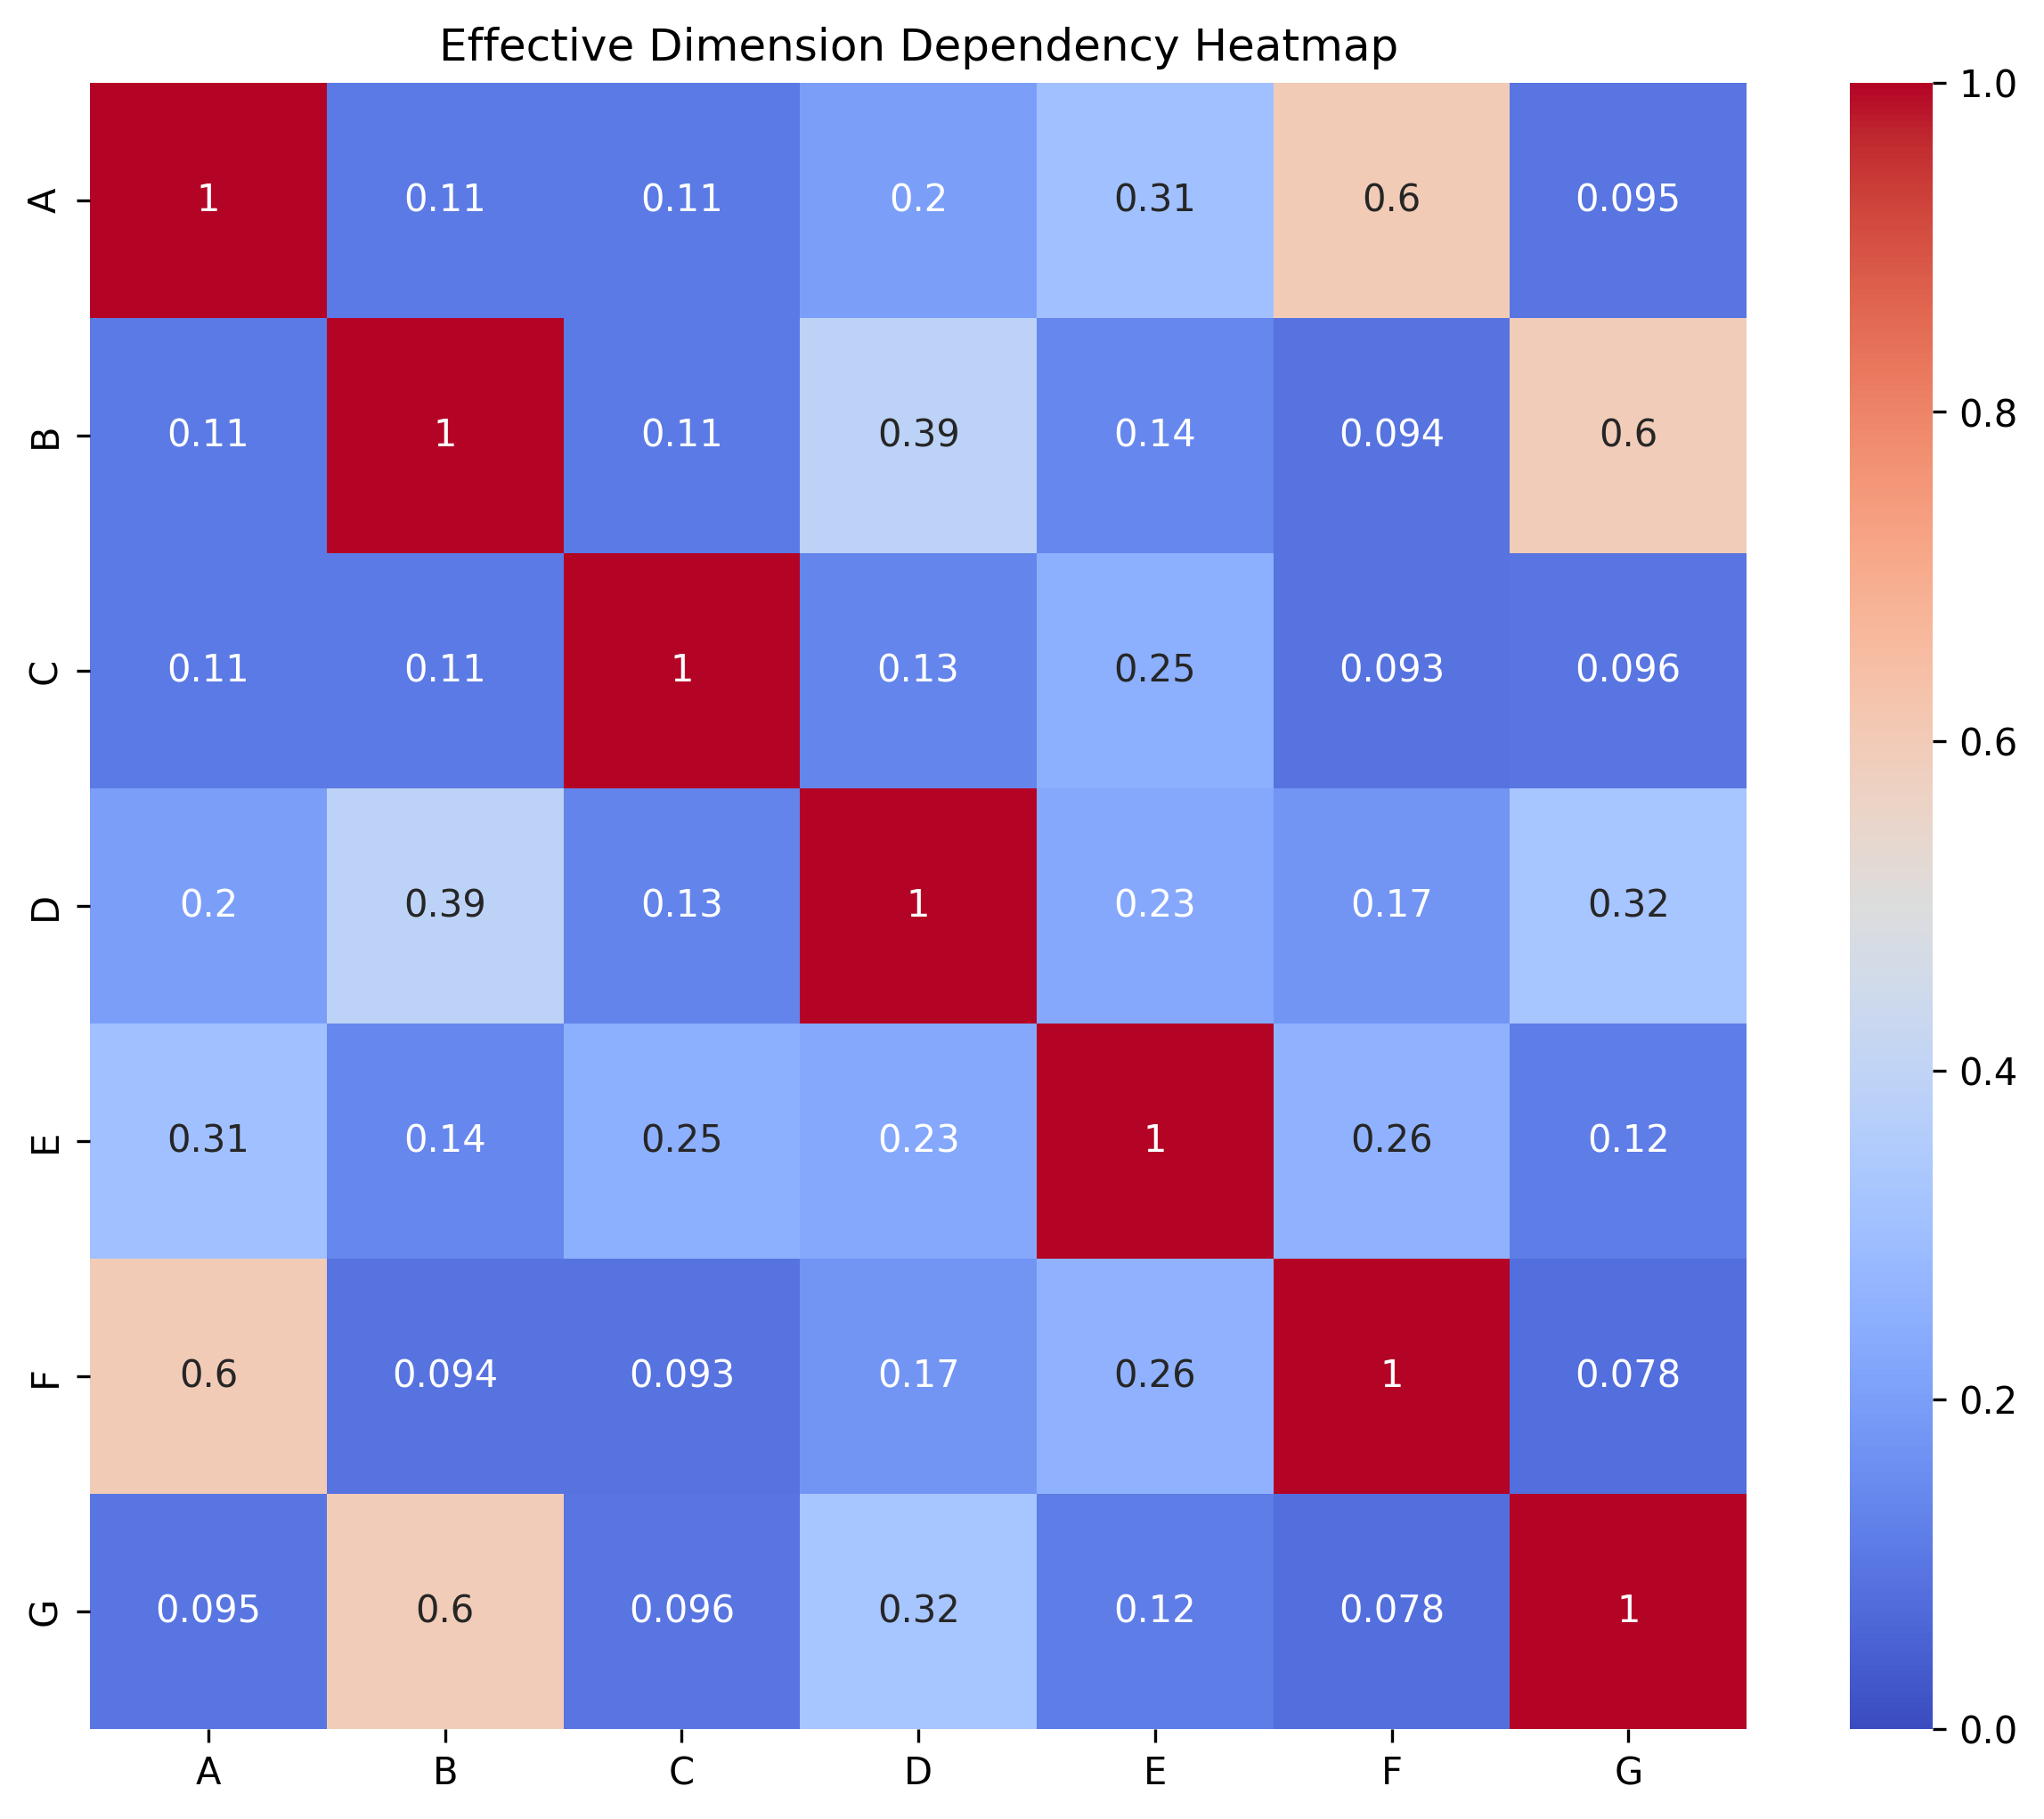

In [2]:
features = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

dependency_matrix = pd.DataFrame(index=features, columns=features)

for feature1 in features:
    for feature2 in features:
        formula = f'y ~ {feature1} + {feature2} + 0'
        dependency_matrix.loc[feature1, feature2] = 2 - compute_temp_eff_dim(df_scaled, formula, num_betas=1000, batch_size=1000) 

dependency_matrix = dependency_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8), dpi=DPI)
sns.heatmap(dependency_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Effective Dimension Dependency Heatmap')
plt.show()

# Parameter Selection

In [2]:
formula_full = f'y ~ {" + ".join(train.drop("y", axis=1).columns)} + 0'

model_full, parameters_full, result_full = fit_wo_con(train, formula_full)

print(result_full.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                70000
Model:                            GLM   Df Residuals:                    69995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -35950.
Date:                Fri, 24 May 2024   Deviance:                       46687.
Time:                        18:30:36   Pearson chi2:                 6.98e+04
No. Iterations:                    47   Pseudo R-squ. (CS):            0.02225
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
A             -0.5602   5.05e+05  -1.11e-06      1.0

Text(0, 0.5, 'Change in Normalize Effective Dimension')

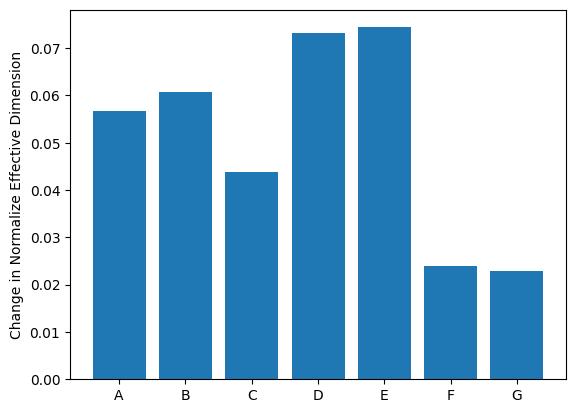

In [3]:

eff_dim_full = compute_temp_eff_dim(df_scaled, formula_full, 1000)[0] / len(features)

changes = []
for feature in features:
    formula_reduced = f'y ~ {" + ".join([f for f in features if f != feature])} + 0'
    changes.append(
        compute_temp_eff_dim(df_scaled, formula_reduced, 1000)[0] / (len(features) - 1)
        - 
        eff_dim_full
    )

plt.bar(features, changes)
plt.ylabel('Change in Normalize Effective Dimension')

In [4]:
formula_wo_E = f'y ~ {" + ".join(train.drop(["y", "E"], axis=1).columns)} + 0'

model_wo_E, parameters_wo_E, result_wo_E = fit_wo_con(train, formula_wo_E)

print(result_wo_E.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                70000
Model:                            GLM   Df Residuals:                    69995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -35950.
Date:                Fri, 24 May 2024   Deviance:                       46687.
Time:                        21:19:26   Pearson chi2:                 6.98e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02225
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
A             -0.6754   9.75e+04  -6.93e-06      1.0

Text(0, 0.5, 'Change in Normalize Effective Dimension')

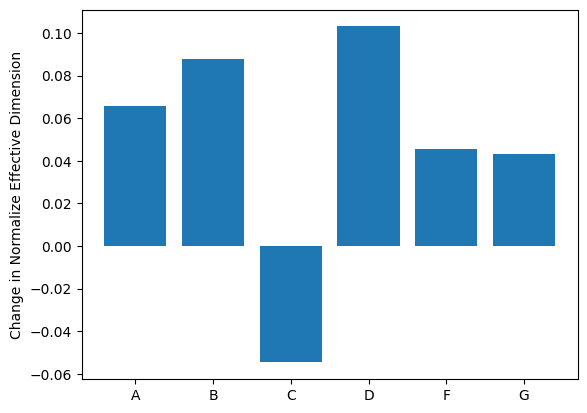

In [6]:
features_wo_E = ['A', 'B', 'C', 'D', 'F', 'G']

eff_dim_wo_E = compute_temp_eff_dim(df_scaled, formula_wo_E, 1000)[0] / len(features_wo_E)

changes = []
for feature in features_wo_E:
    formula_reduced = f'y ~ {" + ".join([f for f in features_wo_E if f != feature])} + 0'
    changes.append(
        compute_temp_eff_dim(df_scaled, formula_reduced, 1000)[0] / (len(features_wo_E) - 1)
        - 
        eff_dim_wo_E
    )

plt.bar(features_wo_E, changes)
plt.ylabel('Change in Normalize Effective Dimension')

In [7]:
formula_wo_ED = f'y ~ {" + ".join(train.drop(["y", "E", "D"], axis=1).columns)} + 0'

model_wo_ED, parameters_wo_ED, result_wo_ED = fit_wo_con(train, formula_wo_ED)

print(result_wo_ED.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                70000
Model:                            GLM   Df Residuals:                    69995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -35950.
Date:                Fri, 24 May 2024   Deviance:                       46687.
Time:                        21:22:40   Pearson chi2:                 6.98e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02225
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
A             -0.8258      0.193     -4.285      0.0

In [9]:
_ = backward_wo_con(train, 'y ~ A + B + C + F + G + 0')

Removing G with p-value 0.8588239674752476
y ~ A + B + C + F + 0
Removing F with p-value 0.841026684542875
y ~ A + B + C + 0
Removing C with p-value 0.6709508408145866
y ~ A + B + 0


In [10]:
formula_true = f'y ~ A + B + 0'

model_true, parameters_true, result_true = fit_wo_con(train, formula_true)

print(result_true.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                70000
Model:                            GLM   Df Residuals:                    69998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -35951.
Date:                Fri, 24 May 2024   Deviance:                       46688.
Time:                        21:23:43   Pearson chi2:                 6.98e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02225
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
A             -0.8787      0.022    -40.019      0.0

# GLM Fit With Constraint

In [13]:
_, _, _, result_wo_con = fit_w_con(train, 'y ~ A + B + 0', 0.01, 0.5)

result_wo_con.x

array([-0.87883527, -0.82237364])

# Cap Values

Computing Eigenvalues: 100%|██████████| 100/100 [00:04<00:00, 20.68it/s]


0.4906136439462487 -3.510378907315872e-17 0.05972075535222723
proportion cap=1: 0.17509


Computing Eigenvalues: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


0.4440081875282847 -5.341993350139151e-17 0.05404856888869892
proportion cap=2: 0.01771


Computing Eigenvalues: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


0.487324982491367 -3.7990651671889365e-17 0.059320444609465645
proportion cap=3: 0.00131


Computing Eigenvalues: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


0.49042453989583656 -3.622566824608401e-17 0.059697729803066896


Text(0.5, 0.98, 'Normalized Effective dimension of Full GLM Model with Varying Cap Values')

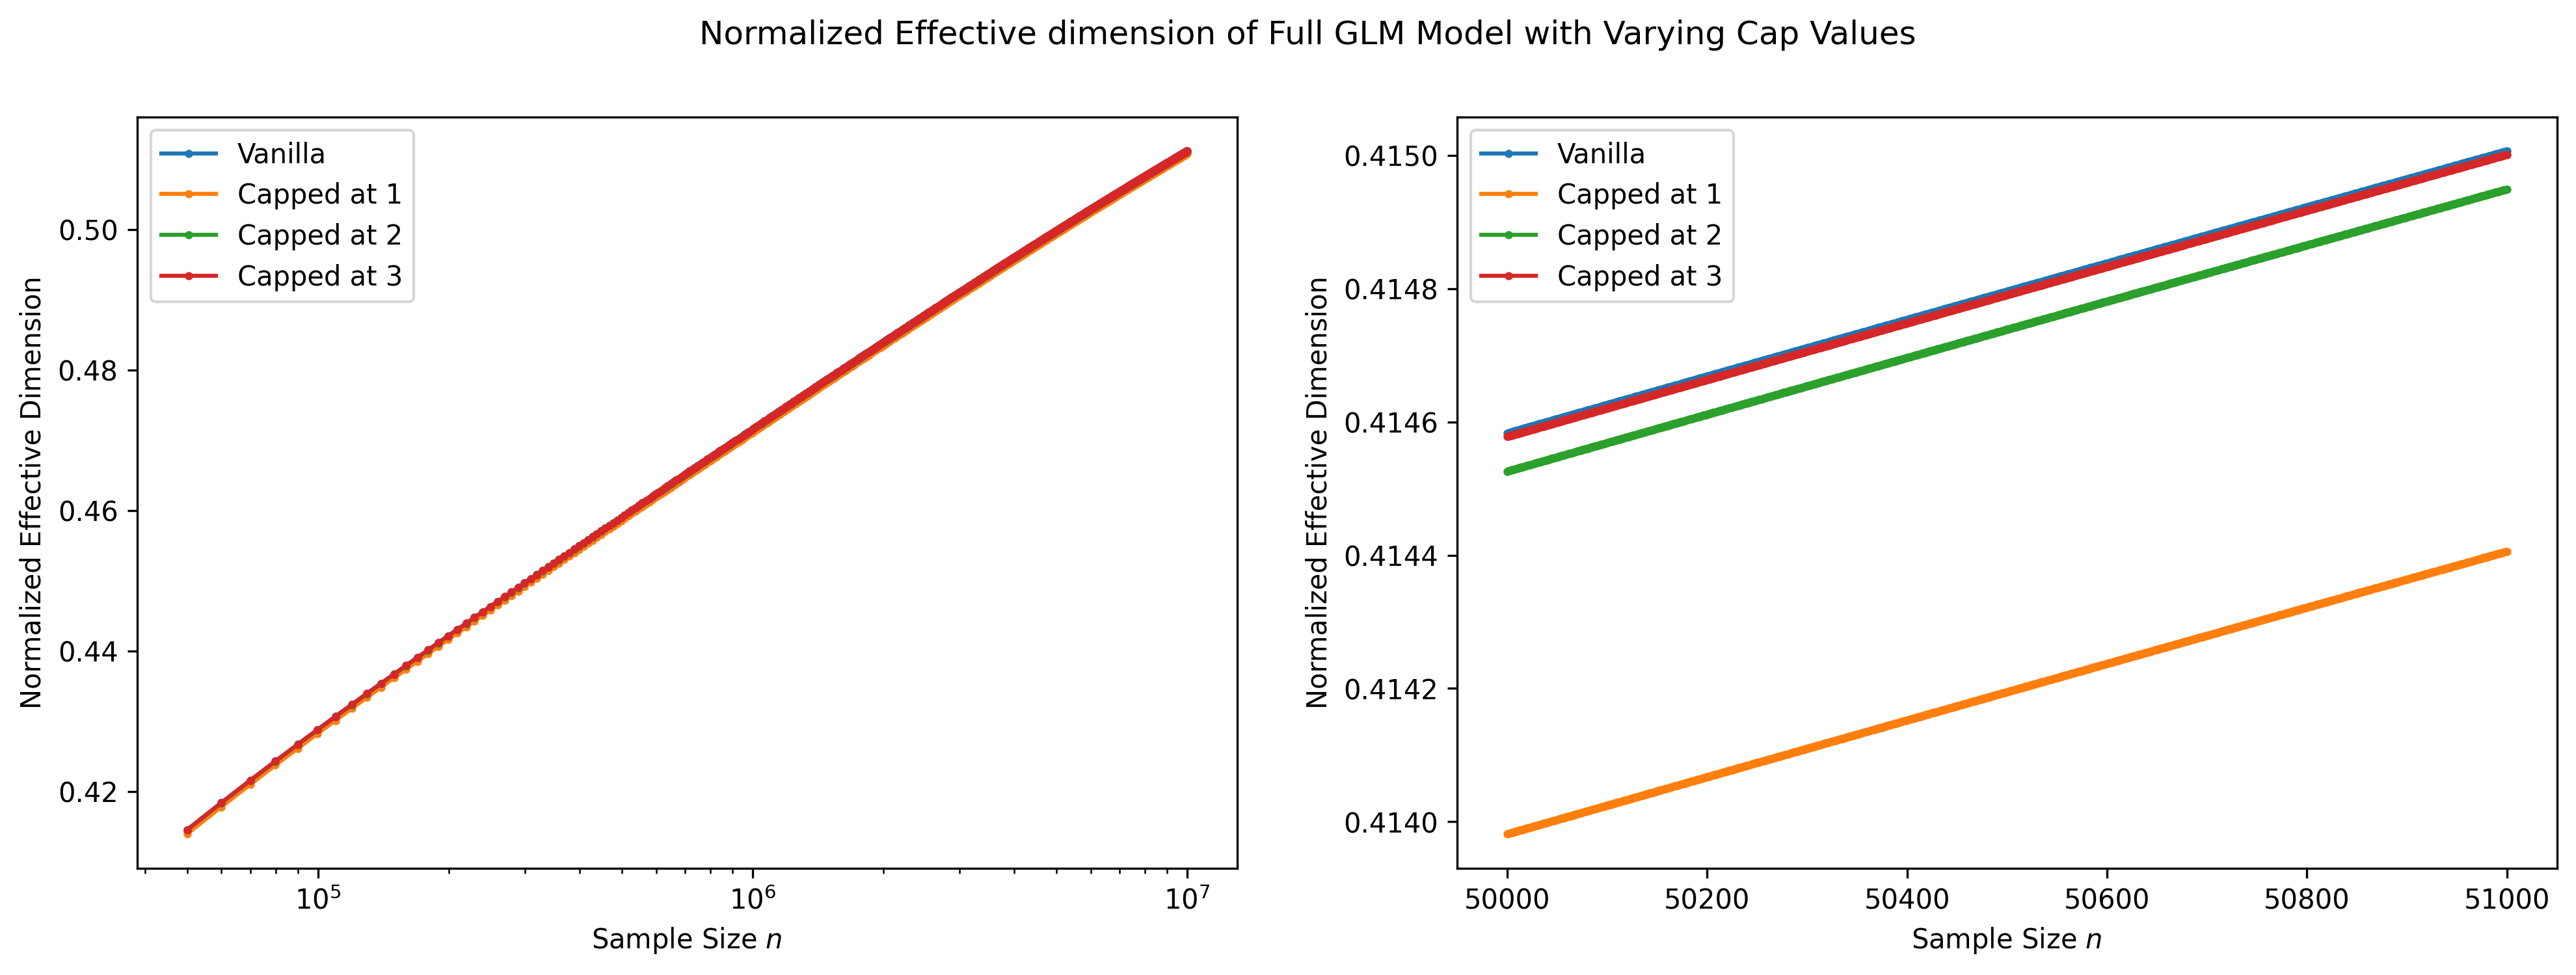

: 

In [2]:
util = PlotUtil()

fig, axs = plt.subplots(1, 2, figsize=TWO_PLOTS_FIGSIZE, dpi=DPI)

features = df.drop('y', axis=1).columns

for i in range(4):
    _ = compute_fims_glm(
        len(features),
        1000,
        save_dir=os.path.join(eigenvalues_dir, 'temp'),
        features=df[features].values,
        filename='temp',
        response=df['y'],
        cap=i if i > 0 else None,
        batch_size=5
    )


    gamma = 1

    options: List[PlotOption] = [
        PlotOption(os.path.join(eigenvalues_dir, 'temp', f'temp_{len(features)}.h5'), 'Vanilla' if i == 0 else f'Capped at {i}', 
                normalized=True, dim=len(features), ed_type=EDType.GLOBAL, gamma=gamma, chunk_size=1000, verbose=False),
    ]

    util.plot(
        options,

        n_min=int(5e4),
        n_max=int(1e7),

        ylabel="Normalized Effective Dimension",

        axis_option=AxisOption.SEMILOGX,

        ax=axs[0],
    )

    # For a closer look
    util.plot(
        options,

        
        n_min=int(5e4),
        n_max=int(5.1e4),

        ylabel="Normalized Effective Dimension",

        axis_option=AxisOption.PLOT,

        ax=axs[1]
    )

fig.suptitle('Normalized Effective dimension of Full GLM Model with Varying Cap Values')